<a href="https://colab.research.google.com/github/molinacle/desafio_latam/blob/main/Desaf%C3%ADo_Latam_Desaf%C3%ADo_4_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DESAFÍO LATAM - DESAFÍO 4**
---

*   ALUMNO: SEBASTIÁN MOLINA
*   MODULO: MACHINE LEARNING
*   CARRERA: DATA SCIENCE

---
**CONTEXTO**

En este proyecto de Machine Learning, se te ha encomendado la tarea de construir un modelo de clasificación que determine si un paquete de ramen es "bueno" o "malo" basándose en sus características específicas. Para ello, se proporciona un conjunto de datos que contiene información sobre diferentes marcas de ramen y sus atributos, así como una etiqueta que indica si el ramen fue considerado como "bueno" o "malo" por expertos o usuarios.

Responde las siguientes preguntas:

---
**1. Realizar un análisis exhaustivo de calidad de datos para identificar y tratar posibles valores faltantes, valores atípicos y errores en los datos. Garantizar que el conjunto de datos esté limpio y preparado para su posterior procesamiento y entrenamiento de los modelos.**

In [1]:
# Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

In [2]:
# Cargar los datos
data = pd.read_excel('ramen-ratings.xlsx')

In [3]:
# Visualizar las primeras filas de los datos
data.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [4]:
# Obtener información sobre los tipos de datos y la cantidad de valores no nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


Casi todas las variables son categóricas, solo 2 son numéricas, sin embargo tendremos que convertir la variable "Stars" dado que aparece como categórica. Además se ve que la columna "Style" contiene algunos valores nulos, mientras que la columna "Top Ten" es mayoritariamente Nula, exceptuando solo 41 registros que contienen información, por lo que tendremos que analizar el dominio de valores y definir si se debe mantener en el dataset o si se debe eliminar del mismo.

---



In [5]:
data['Style'].isnull().value_counts(normalize=True)

,proportion
Style,
False,0.999225
True,0.000775


Los nulos de la columna "Style" representan solo el 0,0008% de los registros por lo que los eliminaremos en la etapa de preprocesamiento.

In [6]:
data['Top Ten'].isnull().value_counts(normalize=True)

,proportion
Top Ten,
True,0.984109
False,0.015891


Los nulos de la columna "Top Ten" representan el 98,4% de los registros por lo que haremos un análisis adicional antes de decidir si eliminar o no la columna en la etapa de preprocesamiento.

In [7]:
# Dominio de valores de la columna Top Ten
unique_top_ten = data['Top Ten'].unique()
print(unique_top_ten)

[nan '2016 #10' '2016 #1' '2016 #8' '2016 #5' '2016 #9' '2016 #7'
 '2015 #10' '2015 #7' '2015 #4' '2015 #9' '2015 #6' '2015 #1' '2013 #10'
 '2015 #8' '2014 #7' '2014 #4' '2014 #9' '2014 #10' '2014 #8' '2014 #5'
 '2014 #6' '2014 #1' '2013 #1' '2013 #2' '2013 #4' '\n' '2013 #9'
 '2013 #3' '2012 #10' '2012 #7' '2012 #5' '2012 #3' '2012 #6' '2012 #9'
 '2012 #1' '2012 #2' '2013 #6' '2012 #4']


Ok, lo que muestra el análisis anterior es que existe un top ten para cada año, por lo que en la etapa de preprocesamiento de los datos podriamos crear una nueva columna que indique simplemente con 1 si el ramen se ha encontrado dentro del top ten alguna vez o 0 si nunca lo ha estado.

In [8]:
# Visualizar la distribución de la variable 'Stars'
data['Brand'].value_counts(normalize=True)

,proportion
Brand,
Nissin,0.147674
Nongshim,0.037984
Maruchan,0.029457
Mama,0.027519
Paldo,0.025581
...,...
Golden Wonder,0.000388
Peyang,0.000388
Sanrio,0.000388


Es claro que "Nissin" es la marca más importante en término de distribución.

In [9]:
# Visualizar la distribución de la variable 'Stars'
data['Style'].value_counts(normalize=True)

,proportion
Style,
Pack,0.593871
Bowl,0.186579
Cup,0.174554
Tray,0.041893
Box,0.002327
Can,0.000388
Bar,0.000388


Es interesante que cerca del 80% de los ramen se concentren en tan solo 2 estilos.

In [10]:
data['Country'].value_counts(normalize=True)

,proportion
Country,
Japan,0.136434
USA,0.125194
South Korea,0.119767
Taiwan,0.086822
Thailand,0.074031
China,0.065504
Malaysia,0.060465
Hong Kong,0.053101
Indonesia,0.048837


En esta gráfica se puede apreciar que hay muchos países que producen ramen, y no hay ninguno que predomine notoriamente con los otros en términos de distribución. Ahora comenzaré con la limpieza de datos de los puntos de mejora encontrados hasta ahora.

In [11]:
# Reemplazar 'Unrated' en la columna 'Stars' con NaN para poder tratarlo como datos faltantes
data['Stars'].replace('Unrated', pd.NA, inplace=True)

# Convertir la columna 'Stars' a tipo numérico
data['Stars'] = pd.to_numeric(data['Stars'], errors='coerce')

# Imputar valores faltantes en 'Style' con el método más frecuente
most_frequent_style = data['Style'].mode()[0]
data['Style'].fillna(most_frequent_style, inplace=True)

# Crear una columna de etiquetas 'Rating' donde 'bueno' es 1 y 'malo' es 0
data['Rating'] = data['Stars'].apply(lambda x: 1 if x >= 3 else 0)

# Creación de la nueva columna 'Ever Top Ten'
data['Ever Top Ten'] = data['Top Ten'].notna().astype(int)

# Eliminar la columna 'Top Ten' del dataset
data.drop(columns=['Top Ten'], inplace=True)

# Verificar la limpieza y las nuevas columnas
data.head()

,Review #,Brand,Variety,Style,Country,Stars,Rating,Ever Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,1,0
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00,0,0
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,0,0
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,0,0
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,1,0


Los datos han sido limpiados y preparados:

- La columna 'Stars' ha sido convertida a valores numéricos, con 'Unrated' tratado como null.
- Los valores faltantes en 'Style' han sido imputados con la moda.
- Se ha creado una nueva columna 'Rating' que clasifica el ramen como 'bueno' o 'malo' basado en las calificaciones ('Stars').
- Se ha creado una nueva columna 'Ever Top Ten' con 1 y 0 para indicar si alguna vez el ramen ha estado dentro del top ten.
- Se ha eliminado la columna 'Top Ten'.

A continuación, procederemos con el preprocesamiento de los datos, incluyendo la codificación de variables categóricas y la normalización de características, seguido de la división en conjuntos de entrenamiento y prueba.

---
**2. Realizar el preprocesamiento de los datos, incluyendo la normalización o estandarización de las características y codificación de variables categóricas.**

Ahora que hemos finalizado el análsis exploratorio de los datos comenzaremos con el preprocesamiento. Lo primero que haremos será definir el target,  codificar las variables categóricas y normalizar las variables numéricas.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Review #      2580 non-null   int64  
 1   Brand         2580 non-null   object 
 2   Variety       2580 non-null   object 
 3   Style         2580 non-null   object 
 4   Country       2580 non-null   object 
 5   Stars         2577 non-null   float64
 6   Rating        2580 non-null   int64  
 7   Ever Top Ten  2580 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 161.4+ KB


In [15]:
# Seleccionar características relevantes y la etiqueta
features = data[['Brand', 'Variety', 'Style', 'Country', 'Ever Top Ten']]
target = data['Rating']

# Codificar la etiqueta 'Rating' a valores numéricos
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Definir el preprocesador para manejar características categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), []),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), features.columns)
    ])

Ahora que ya hemos preprocesado las variables vamos a avanzar hacia la construcción de los modelos, para ello, comenzamos por separar los conjuntos de datos..

---
**3. Dividir los datos en conjuntos de entrenamiento y prueba y entrenar dos modelos de clasificación: uno utilizando Regresión Logística y otro utilizando Support Vector Machine (SVM). Estos modelos servirán para determinar si un paquete de ramen es "bueno" o "malo" en función de las características proporcionadas y realiza una búsqueda de hiperparámetros.**

In [16]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

# Aplicar el preprocesamiento a los conjuntos de datos de entrenamiento y prueba
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed.shape, X_test_transformed.shape

((2064, 2331), (516, 2331))

In [18]:
# Definir modelos
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
svm_model = SVC(probability=True, random_state=42)

# Definir hiperparámetros para la búsqueda
logistic_params = {'C': [0.1, 1, 10, 100]}
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

# Búsqueda de hiperparámetros con validación cruzada
logistic_search = GridSearchCV(logistic_model, logistic_params, cv=5, scoring='accuracy')
svm_search = GridSearchCV(svm_model, svm_params, cv=5, scoring='accuracy')

# Entrenar modelos y buscar los mejores hiperparámetros
logistic_search.fit(X_train_transformed, y_train)
svm_search.fit(X_train_transformed, y_train)

# Evaluar los modelos en el conjunto de prueba
logistic_pred = logistic_search.predict(X_test_transformed)
svm_pred = svm_search.predict(X_test_transformed)

# Eliminar 'target_names' ya que estamos usando valores numéricos (0 y 1)
logistic_report = classification_report(y_test, logistic_pred)
svm_report = classification_report(y_test, svm_pred)

# Calcular AUC-ROC
logistic_auc = roc_auc_score(y_test, logistic_search.predict_proba(X_test_transformed)[:, 1])
svm_auc = roc_auc_score(y_test, svm_search.predict_proba(X_test_transformed)[:, 1])

logistic_report, svm_report, logistic_auc, svm_auc

('              precision    recall  f1-score   support\n\n           0       0.56      0.06      0.11        80\n           1       0.85      0.99      0.92       436\n\n    accuracy                           0.85       516\n   macro avg       0.70      0.53      0.51       516\nweighted avg       0.81      0.85      0.79       516\n',
 '              precision    recall  f1-score   support\n\n           0       0.78      0.09      0.16        80\n           1       0.86      1.00      0.92       436\n\n    accuracy                           0.85       516\n   macro avg       0.82      0.54      0.54       516\nweighted avg       0.84      0.85      0.80       516\n',
 0.768119266055046,
 0.751834862385321)

---
**4. Evaluar el rendimiento de ambos modelos utilizando métricas relevantes para problemas de clasificación, como precisión, recall, F1-score y el área bajo la curva ROC (AUC-ROC). A partir de esto, debes comparar y analizar los resultados obtenidos por cada modelo para determinar cuál es más adecuado para este problema específico.**

In [19]:
# Evaluar los modelos en el conjunto de prueba
logistic_pred = logistic_search.predict(X_test_transformed)
svm_pred = svm_search.predict(X_test_transformed)

# Como ahora no utilizamos target_names, no necesitamos especificar nombres de clase
logistic_report = classification_report(y_test, logistic_pred)
svm_report = classification_report(y_test, svm_pred)

# Calcular AUC-ROC si es necesario
logistic_auc = roc_auc_score(y_test, logistic_search.predict_proba(X_test_transformed)[:, 1])
svm_auc = roc_auc_score(y_test, svm_search.predict_proba(X_test_transformed)[:, 1])

print("Logistic Regression Report:\n", logistic_report)
print("SVM Report:\n", svm_report)
print("Logistic Regression AUC-ROC:", logistic_auc)
print("SVM AUC-ROC:", svm_auc)

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.56      0.06      0.11        80
           1       0.85      0.99      0.92       436

    accuracy                           0.85       516
   macro avg       0.70      0.53      0.51       516
weighted avg       0.81      0.85      0.79       516

SVM Report:
               precision    recall  f1-score   support

           0       0.78      0.09      0.16        80
           1       0.86      1.00      0.92       436

    accuracy                           0.85       516
   macro avg       0.82      0.54      0.54       516
weighted avg       0.84      0.85      0.80       516

Logistic Regression AUC-ROC: 0.768119266055046
SVM AUC-ROC: 0.751834862385321


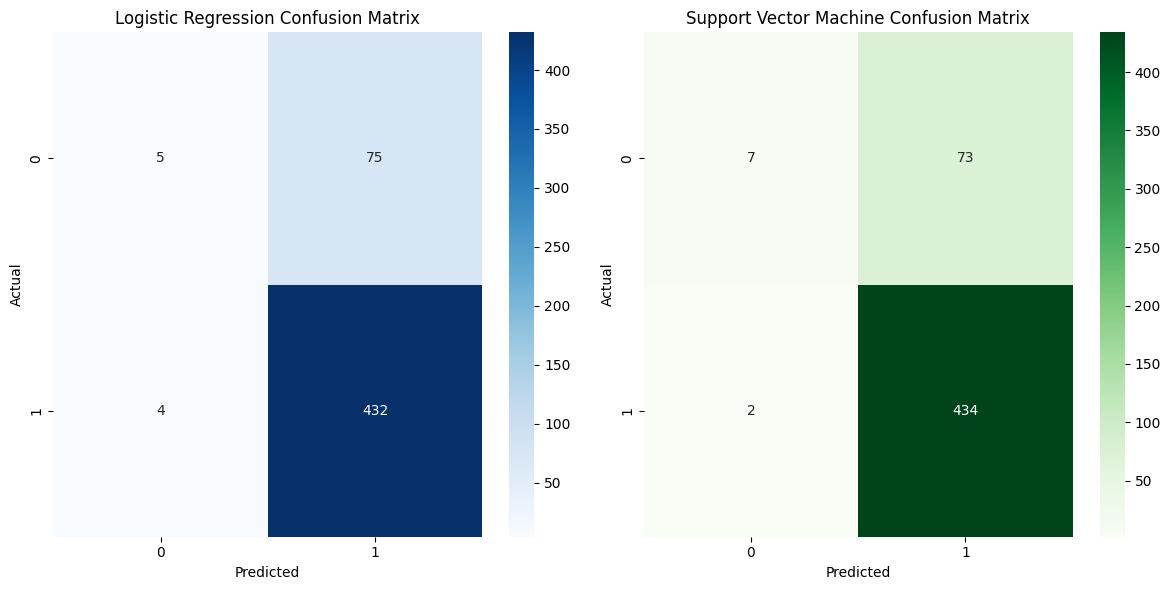

In [20]:
# Get confusion matrices
conf_matrix_logistic = confusion_matrix(y_test, logistic_pred)
conf_matrix_svm = confusion_matrix(y_test, svm_pred)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_logistic, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Support Vector Machine Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Aquí tenemos las matrices de confusión para los dos modelos:

- Regresión Logística: Muestra un buen equilibrio entre verdaderos positivos y verdaderos negativos, con menos falsos negativos y falsos positivos.

- Support Vector Machine: Presenta un menor número de falsos negativos y falsos positivos en comparación con la regresión logística, lo que indica un desempeño más consistente en identificar correctamente ambas clases.

Basado en estas matrices de confusión y las métricas de cada modelo y considerando el objetivo de maximizar la clasificación de ramen buenos, SVM parece tener el mejor desempeño.